Import all library


In [32]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import cv2
import imghdr
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [33]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1


In [34]:
gpus = tf.config.experimental.list_physical_devices("GPU")

for gpu in gpus :
  tf.config.experimental.set_memory_growth(gpu,True)
  
print(gpus)
  

[]


In [35]:
data_dir = './DATASET/DATASET/TRAIN'
list_dir = os.listdir(data_dir)
image_ext = ["jpeg", "jpg", "bmp", "png"]
print(list_dir)

['O', 'R']


In [36]:
for image_class in list_dir :
    for image in os.listdir(os.path.join(data_dir,image_class)):
       image_path = os.path.join(data_dir,image_class,image)
       try:
          img = cv2.imread(image_path)
          tip = imghdr.what(image_path)
          if tip not in image_ext:
             print("Image not in ext list {}".format(image_path))
             os.remove(image_path)
       except Exception as e:
          print("issue with the image {}".format(image_path))

Found 22564 files belonging to 2 classes.


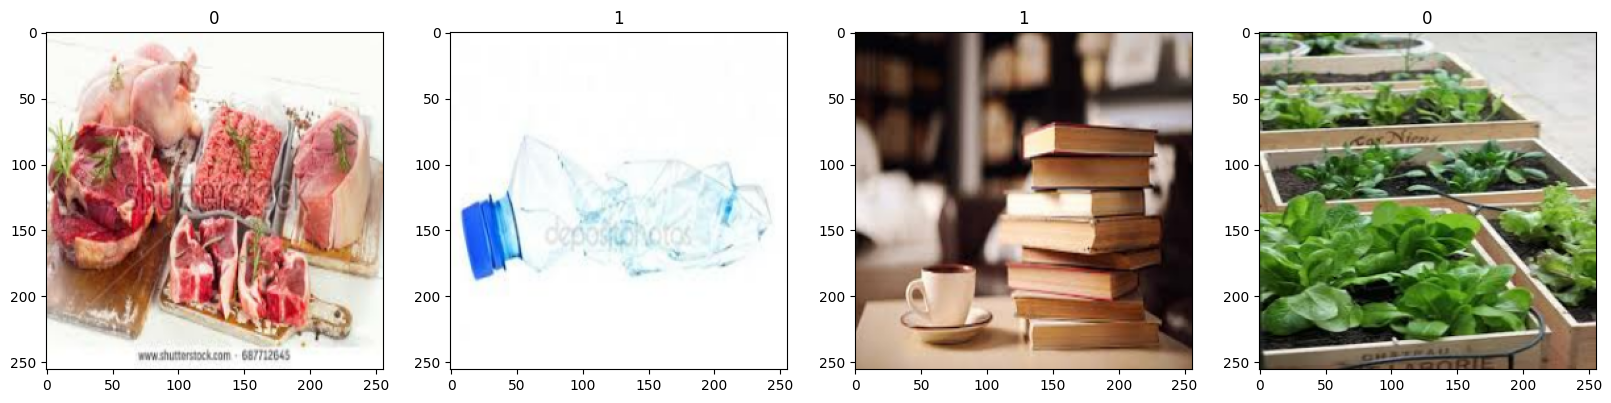

In [37]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

flg,ax = plt.subplots(ncols=4,figsize = (20,20))
for idx,img in enumerate(batch[0][:4]):
   ax[idx].imshow(img.astype(int))
   ax[idx].title.set_text(batch[1][idx])

In [38]:
scaled = batch[0]/255
scaled.max()

1.0

In [39]:
data = data.map(lambda x, y: (tf.image.resize(x, [128, 128]) / 255.0, y))

scaled_iterator = data.as_numpy_iterator()

batch = scaled_iterator.next()
batch[0].min()

0.0

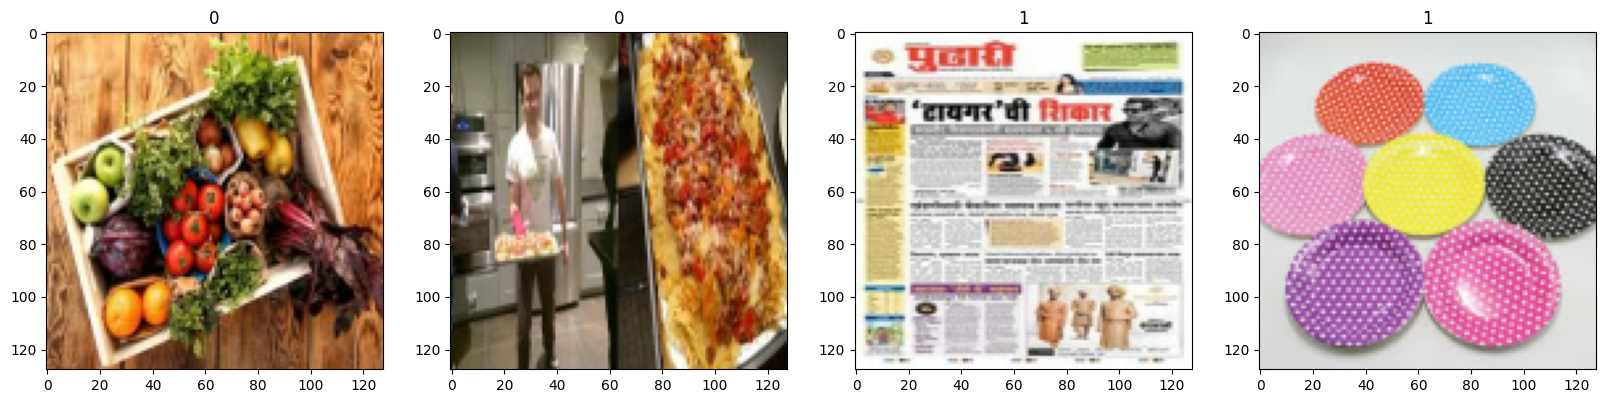

In [40]:
fig,ax = plt.subplots(ncols = 4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [41]:

len(data)

706

In [42]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) 
total = train_size + val_size + test_size
print("all size : ",total)

all size :  706


In [43]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [44]:
len(train)

494

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [46]:
model = Sequential()

In [47]:
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

# Flattening and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [50]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [51]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,265 (32.36 MB)

 Trainable params: 8,482,817 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [52]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback, early_stopping, lr_scheduler])

Epoch 1/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1154s 2s/step - accuracy: 0.7426 - loss: 5.5287 - val_accuracy: 0.7801 - val_loss: 1.4070 - learning_rate: 0.0010
Epoch 2/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1197s 2s/step - accuracy: 0.7916 - loss: 0.9589 - val_accuracy: 0.6426 - val_loss: 1.2555 - learning_rate: 0.0010
Epoch 3/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1092s 2s/step - accuracy: 0.8054 - loss: 0.9618 - val_accuracy: 0.8206 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 4/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1099s 2s/step - accuracy: 0.8198 - loss: 0.6981 - val_accuracy: 0.8404 - val_loss: 0.5214 - learning_rate: 0.0010
Epoch 5/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1101s 2s/step - accuracy: 0.8360 - loss: 0.5640 - val_accuracy: 0.8479 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 6/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 1096s 2s/step - accuracy: 0.8386 - loss: 0.5712 - val_accuracy: 0.8048 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 7/20
494/494 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8452 - loss

In [54]:
hist.history

{'accuracy': [0.7687246799468994,
  0.7979503870010376,
  0.8148406147956848,
  0.82363361120224,
  0.8362221717834473,
  0.8432439565658569,
  0.8476720452308655,
  0.8670926094055176,
  0.8694964647293091],
 'loss': [2.922374963760376,
  0.8490099310874939,
  0.7964962124824524,
  0.6919660568237305,
  0.57094806432724,
  0.5486782193183899,
  0.5521752834320068,
  0.45497992634773254,
  0.4590650498867035],
 'val_accuracy': [0.7801496386528015,
  0.6426056623458862,
  0.8206425905227661,
  0.8404489159584045,
  0.8479313254356384,
  0.8047975301742554,
  0.8329665660858154,
  0.8098591566085815,
  0.8122799396514893],
 'val_loss': [1.4069569110870361,
  1.2555423974990845,
  0.6898940205574036,
  0.5213896632194519,
  0.5637041926383972,
  0.5685057044029236,
  0.5340177416801453,
  0.5653014779090881,
  0.5666768550872803],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.00100000004749

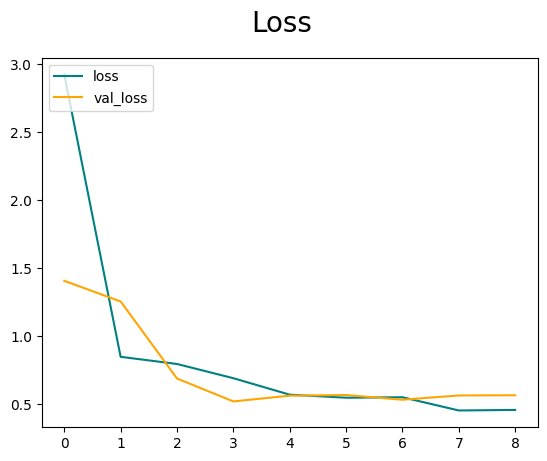

In [55]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize = 20)
plt.legend(loc="upper left")
plt.show()

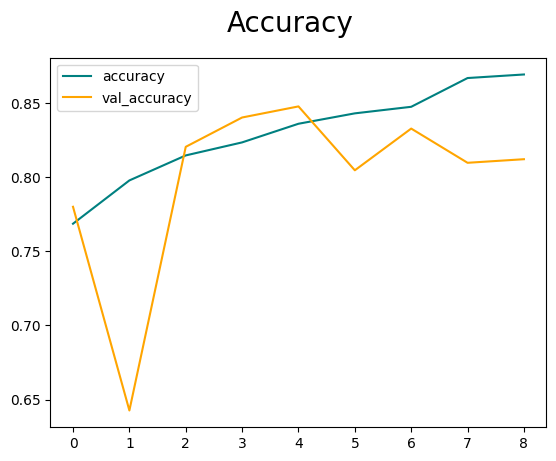

In [56]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize = 20)
plt.legend(loc="upper left")
plt.show()

In [57]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy

In [58]:

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [59]:

len(test)

70

In [60]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [62]:
print(f'Presicions : {pre.result().numpy()}, Recall : {re.result().numpy()}, acc : {acc.result().numpy()}')

Presicions : 0.8292433619499207, Recall : 0.8109999895095825, acc : 0.8390596508979797


In [116]:
img = cv2.imread('DATASET/DATASET/TEST/O/O_13944.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

: 

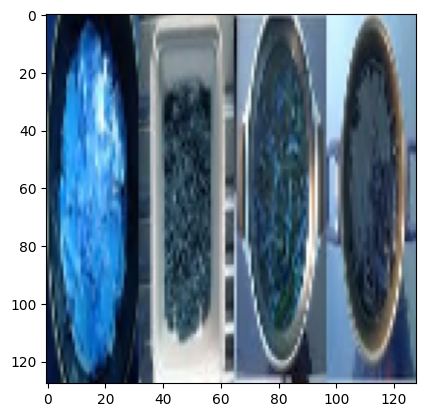

In [117]:
resize = tf.image.resize(img,(128,128))
plt.imshow(resize.numpy().astype(int))
plt.show()
     

In [118]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


In [119]:
yhat 

array([[0.84578645]], dtype=float32)

In [120]:
# 0 = Organik , 1 = Non Organik

if yhat < 0.9:
    print('Organik')
elif yhat >= 0.91:
    print('Non Organik')



Organik


In [127]:
from tensorflow.keras.models import load_model

In [128]:
model.save(os.path.join("models","ModelSampah.h5"))

In [129]:
new_model = load_model(os.path.join("models","ModelSampah.h5"))

In [130]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [131]:
if yhat < 0.9:
    print('Organik')
elif yhat >= 0.91:
    print('Non Organik')

Organik
